# Seeing how the Deep SDM learns

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
sys.path.append('../py_scripts')
import matplotlib.pyplot as plt
from py_scripts import LightningDataModule, get_params_net_dataloader, ModelStyles, DataSet
import pytorch_lightning as pl
import wandb
import torch 
from pytorch_lightning.loggers import WandbLogger
import numpy as np
import torchvision
from torchvision.utils import make_grid
import pandas as pd 
import torch.optim as optim
import torch.nn.functional as F

# gpu check
!nvidia-smi

Sat Dec 11 17:58:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1E:00.0 Off |                    0 |
| N/A   42C    P0    57W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Plotting Functions

In [2]:
# plotting functions 

def tplt(img):
    plt.imshow(img.detach().cpu().numpy())
    plt.show()
    
def pre_make_grid_tensor(tp):
    if torch.is_tensor(tp):
        tp =tp.detach().cpu()
    else:
        tp=torch.Tensor(data_module.test_data.data[inds]).squeeze().permute(0,3,1,2)/255
        if params.force_grayscale:
            tp = transforms.Grayscale()(tp)
    return tp

def imshow(img, show_now=True):
    """
    Used by Pytorch grid function to display lots of images at the same time using the same visualization range. 
    """
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if show_now: # want this false if trying to save figure elsewhere before showing it. 
        plt.show()

def recombine(ptchs, out_size = 28, stride=1):
    # cant have any batching. 
    # dim eg of torch.Size([ 24, 24, 5, 5])
    ptchs = ptchs.unsqueeze(0).unsqueeze(0)
    kernel_size = params.filter_len
    patches = ptchs.contiguous().view(1, 1, -1, kernel_size*kernel_size)
    patches = patches.permute(0, 1, 3, 2)
    patches = patches.contiguous().view(1, kernel_size*kernel_size, -1)
    #ps.fold(d_len-2, params.filter_len, stride).fold(d_len-1, params.filter_len, stride).shape
    combo = torch.nn.Fold(output_size = (out_size,out_size), kernel_size=params.filter_len)(patches)
    return combo.squeeze()

In [3]:
# set from nvidia-smi check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if str(device) =="cuda":
    gpus = [0]
else: 
    gpus = None
    

In [5]:
from types import SimpleNamespace
load_path = "../"+"wandb_Logger/Foundational-SDM/3ooskhu7/checkpoints/epoch=104-step=41054.ckpt"
# AlexNet early stopping. Should really try the longer trained model too. "wandb_Logger/Foundational-SDM/3f6iuxtq/checkpoints/epoch=24-step=9774.ckpt"
# grayscale high performing 7 layer CIFAR10 DeepSDM "wandb_Logger/Foundational-SDM/1tztk54a/checkpoints/epoch=49-step=19549.ckpt"

checkpoint = torch.load(load_path, map_location=device)
params = checkpoint['hyper_parameters']
params = SimpleNamespace(**params)

In [6]:

# set the gaba switch or the k value!
extras = {
    "num_workers":4,
    "device":device,
    "dataset_path":"../data"
}

params, model, data_module = get_params_net_dataloader(params.model_style, params.dataset,load_from_checkpoint=load_path, **extras)

Final params being used namespace(Frey_paper_rep_WT=False, act_func=ReLU(), act_string='ReLU()', active_threshold=0.3, all_positive_weights=True, batch_size=128, dataset=<DataSet.CIFAR10: 2>, dataset_str='CIFAR10', device=device(type='cuda'), dropout_prob=0.0, early_stopping=False, epochs_to_train_for=500, filter_len=3, force_grayscale=False, full_color_norm=False, gaba_switch_logging_layer=2, gradient_clip=1000, nneurons=[1000], hoyer_weight=0.0, img_dim=32, input_size=3072, k_max=30, k_min=3, k_transition_epochs_to_train_for=20, l1_growth_rate=None, l1_loss_weight=None, l1_max_val=0.3, l2_loss_weight=None, label_iter=range(0, 10), learn_addresses=True, top_k_linear_decay=True, load_path=None, lr=0.001, model_foundation=<class 'models.Deep_SDM.DEEP_SDM'>, model_style=<ModelStyles.DEEP_SDM_CLASSIFICATION: 7>, momentum=0.9, nchannels=3, nclasses=10, nlayers=7, nneurons_per_filter=30, norm_addresses=True, norm_values=False, num_activations_for_gaba_switch=10000000, num_receptive_field_im

In [7]:
model = model.to(device)
model.eval()
model.curr_ep = checkpoint['epoch']

""""How to keep training the model: with all the correct settings

trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")

"""

'"How to keep training the model: with all the correct settings\n\ntrainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")\n\n'

In [8]:
model.params

namespace(opt='ADAM',
          momentum=0.9,
          batch_size=128,
          nneurons=[1000],
          act_func=ReLU(),
          lr=0.001,
          epochs_to_train_for=500,
          active_threshold=0.3,
          sparsity_threshold=0.0001,
          num_receptive_field_imgs=10,
          num_workers=4,
          use_gaba_switch=False,
          num_activations_for_gaba_switch=10000000,
          l2_loss_weight=None,
          l1_loss_weight=None,
          l1_growth_rate=None,
          l1_max_val=0.3,
          dropout_prob=0.0,
          hoyer_weight=0.0,
          svdo=False,
          svdo_kl_weight=0.0,
          gradient_clip=1000,
          Frey_paper_rep_WT=False,
          top_k_linear_decay=True,
          use_top_k=True,
          k_transition_epochs_to_train_for=20,
          reconstruction=False,
          use_bias=False,
          norm_addresses=True,
          norm_values=False,
          learn_addresses=True,
          all_positive_weights=True,
          posi

# Check Model Performance and get Neuron Activities

In [8]:
alexnet = True if "ALEX" in params.model_style.name else False
    

In [9]:
# evaluate the model: 

data_module.setup(None)
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()
for train_o_test, loader in zip(['Train', 'Test'], [train_loader, test_loader]):
    with torch.no_grad(): 
        accuracies = []
        if train_o_test == 'Test':
            if alexnet: 
                layerwise_activation_storage = None
            else: 
                layerwise_activation_storage = {ind:None for ind in range(model.params.nlayers+1)}
            data_labels = []
        for dind, data in enumerate(loader): 
            if dind % 10==0:
                print( 'batch ind:', dind )
            x, y = data
            x, y = x.to(device), y.to(device)
            if alexnet:
                logits, _ = model.forward(x)
            else: 
                logits, activations = model.forward(x, output_all_activations=True, log_metrics=False)
            
            if train_o_test == 'Test':
                if alexnet:
                    if layerwise_activation_storage is None:
                        layerwise_activation_storage = logits.cpu()
                    else: 
                        layerwise_activation_storage = torch.cat([layerwise_activation_storage,logits.cpu()],dim=0)
                else: 
                    for ind, act in enumerate(activations):
                        # flip batch and neurons. 
                        if ind != len(activations)-1: # dont need to do this for the last layer. 
                            act = act.permute(1,0,2,3,4)#.contiguous()
                        lact = layerwise_activation_storage[ind]
                        if lact is None:
                            lact = act.cpu()
                        else: 
                            lact = torch.cat([lact,act.cpu()],dim=0)
                        layerwise_activation_storage[ind] = lact
                data_labels += list(y.cpu().numpy()) 

            b_accuracies = (logits.argmax(dim=1)==y)
            #loss = model.compute_loss(logits, y, x)
            accuracies += list(b_accuracies.cpu().numpy())
        print(train_o_test," accuracy", np.mean(accuracies))


Files already downloaded and verified
Files already downloaded and verified


/home/tbb16/anaconda3/envs/core/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch ind: 0
batch ind: 10
batch ind: 20
batch ind: 30
batch ind: 40
batch ind: 50
batch ind: 60
batch ind: 70
batch ind: 80
batch ind: 90
batch ind: 100
batch ind: 110
batch ind: 120
batch ind: 130
batch ind: 140
batch ind: 150
batch ind: 160
batch ind: 170
batch ind: 180
batch ind: 190
batch ind: 200
batch ind: 210
batch ind: 220
batch ind: 230
batch ind: 240
batch ind: 250
batch ind: 260
batch ind: 270
batch ind: 280
batch ind: 290
batch ind: 300
batch ind: 310
batch ind: 320
batch ind: 330
batch ind: 340
batch ind: 350
batch ind: 360
batch ind: 370
batch ind: 380
batch ind: 390
Train  accuracy 0.84728
batch ind: 0
batch ind: 10
batch ind: 20
batch ind: 30
batch ind: 40
batch ind: 50
batch ind: 60
batch ind: 70
Test  accuracy 0.5387


In [10]:
import pickle

write = False 
read = False

if write: 
    with open('../data/notebook_outputs/activations'+params.dataset_str+'.pickle', 'wb') as file: 
        pickle.dump(layerwise_activation_storage, file)

    with open('../data/notebook_outputs/data_labels'+params.dataset_str+'.pickle', 'wb') as file: 
        pickle.dump(data_labels, file)

if read: 
    with open('../data/notebook_outputs/activations'+params.dataset_str+'.pickle', 'rb') as file: 
        layerwise_activation_storage = pickle.load(file)

    with open('../data/notebook_outputs/data_labels'+params.dataset_str+'.pickle', 'rb') as file: 
        data_labels = pickle.load(file)

In [11]:

if alexnet: 
    activation_storage = layerwise_activation_storage
else: 
    lind = 4
    activation_storage = layerwise_activation_storage[lind]
activation_storage.shape 

torch.Size([10000, 30, 1, 22, 22])

In [12]:
data_module.setup(None)
if params.dataset_str == "CIFAR10":
    data_classes = data_module.test_data.classes
elif params.dataset_str == "MNIST":
    data_classes = data_module.test_data.targets # may need to say targets instead
data_classes = np.asarray(data_classes)
data_classes

/home/tbb16/anaconda3/envs/core/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(


array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [13]:
data_labels = np.asarray(data_labels)
activation_storage = torch.abs(activation_storage)

balance_data = False

# useful for the entropy calcs
if balance_data:
    inds_to_keep = []
    for c in params.label_iter:
        #print(( data_labels==c).sum() )
        label_inds = np.arange(len(data_labels))[data_labels==c]
        chosen_inds = np.random.choice(label_inds, size=params.smallest_class_number, replace=False )
        inds_to_keep += list(chosen_inds)
    inds_to_keep = np.asarray(inds_to_keep)

    activation_storage = activation_storage[torch.from_numpy(inds_to_keep).type(torch.long)]
    data_labels = data_labels[inds_to_keep]

activity_per_neuron = activation_storage.sum(0)

# neurons responding to a given input. how many neurons are active. 
active_per_input = activation_storage.sum(1)
active_per_input_thresh = (activation_storage>params.active_threshold).type(torch.float).mean(1)

In [14]:
activity_per_neuron.shape, activity_per_neuron.numel()

(torch.Size([30, 1, 22, 22]), 14520)

Percentage dead neurons tensor(0.7408)


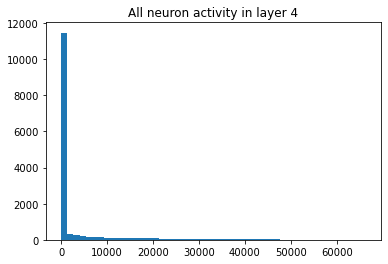

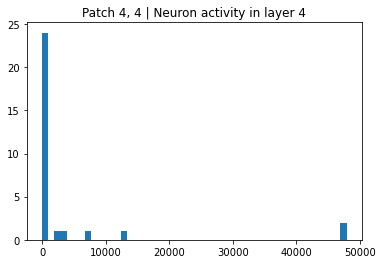

In [15]:
print("Percentage dead neurons", (activity_per_neuron.flatten()<5).sum()/activity_per_neuron.numel())

plt.hist(activity_per_neuron.flatten().cpu().numpy(), bins=50)
plt.title(f"All neuron activity in layer {lind}")
plt.show()

px, py = 4, 4

plt.hist(activity_per_neuron[:, 0, px,py].cpu().numpy(), bins=50)
plt.title(f"Patch {px}, {py} | Neuron activity in layer {lind}")
plt.show()

Neuron Specificity to different inputs

In [16]:

activation_storage.shape

torch.Size([10000, 30, 1, 22, 22])

Non zero class acts [    0     1     2 ... 14512 14517 14519]
Class acts for 0, are [ 20.659086  98.8045    50.34248  132.08678   76.539696 195.17928
 131.3353   104.183846  35.573322  45.80717 ]


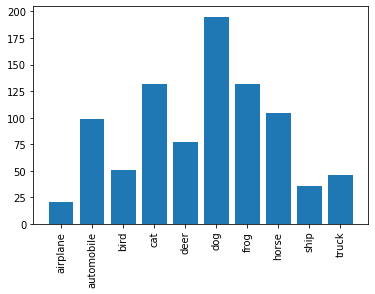

entropy here 2.1349244


In [17]:
flat_act = activation_storage.flatten(start_dim=1)
df = pd.DataFrame( flat_act.cpu().numpy(), columns=list(np.arange(flat_act.shape[1])) )
df["Labels"] = data_labels
df.set_index('Labels', inplace=True)

class_acts = df.groupby("Labels").agg('sum').values
nonzs = np.arange(class_acts.shape[1])[class_acts.sum(0)>0]
print("Non zero class acts",nonzs)
nind=nonzs[0]
print(f"Class acts for {nind}, are {class_acts[:,nind]}")

plt.bar(data_classes, class_acts[:,nind])
if params.dataset_str == "CIFAR10":
    plt.xticks(rotation=90)
plt.show()

# demo entropy calc here: 
act_pdf = class_acts[:,nind] / class_acts[:,nind].sum() 
z_inds = (act_pdf==0.0)
act_pdf[z_inds] += 1e-15
print("entropy here", -(act_pdf * np.log(act_pdf)).sum(0))

## What types of classes activate each neuron? 

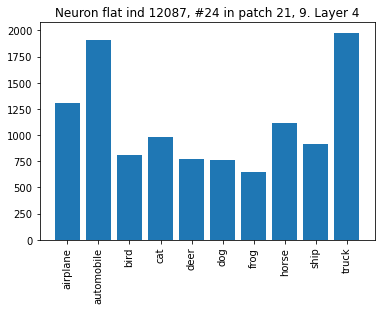

entropy is:  2.228441
activation amounts tensor([5.3926, 5.1497, 5.1447, 5.1152, 5.0644])


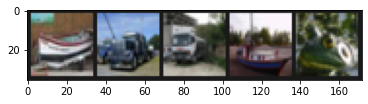

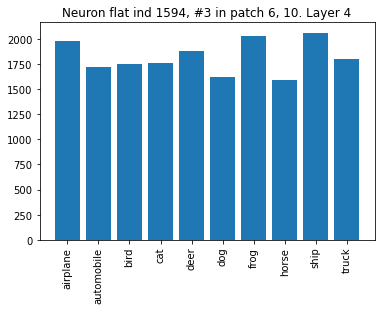

entropy is:  2.2988849
activation amounts tensor([3.6144, 3.5558, 3.5367, 3.5112, 3.5032])


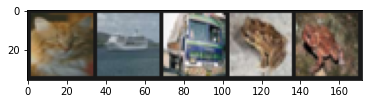

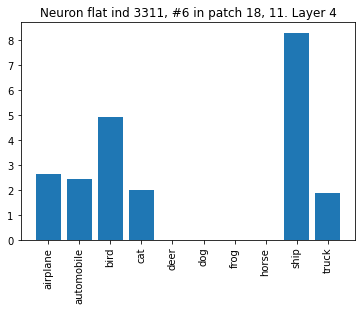

entropy is:  1.6221284
activation amounts tensor([2.4175, 2.1559, 2.1528, 2.1519, 2.1191])


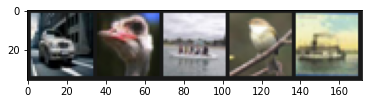

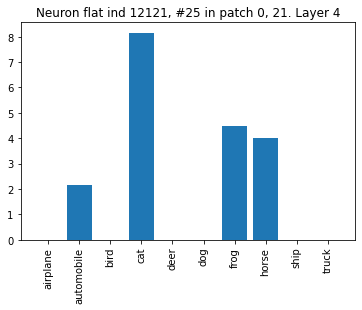

entropy is:  1.2808964
activation amounts tensor([2.3186, 2.3037, 2.1841, 2.1562, 2.1341])


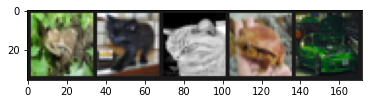

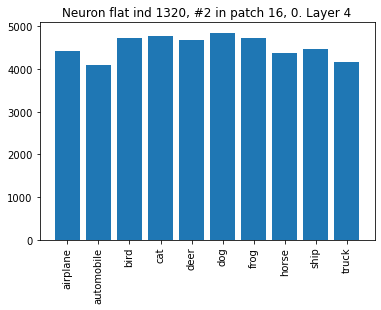

entropy is:  2.3010273
activation amounts tensor([6.7034, 6.6686, 6.6239, 6.6137, 6.5700])


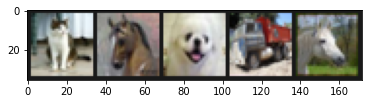

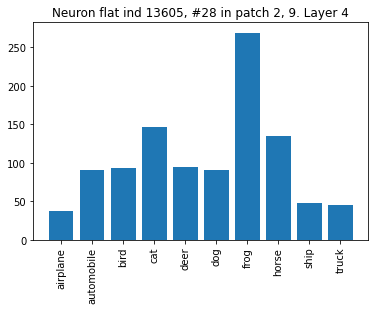

entropy is:  2.136749
activation amounts tensor([4.3375, 4.1725, 4.0968, 4.0131, 3.9645])


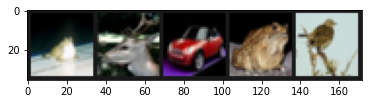

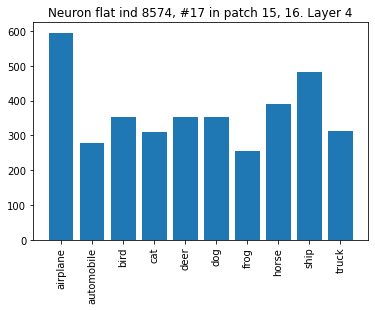

entropy is:  2.2705328
activation amounts tensor([3.5347, 3.4926, 3.4908, 3.4549, 3.4544])


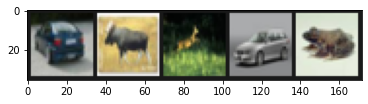

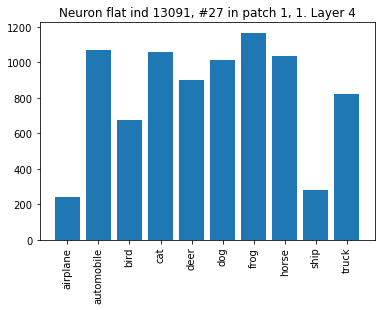

entropy is:  2.2157478
activation amounts tensor([4.6360, 4.6238, 4.5905, 4.5859, 4.5611])


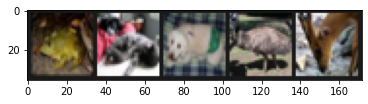

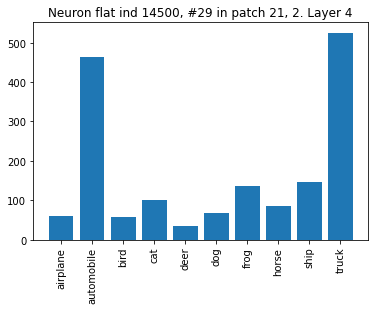

entropy is:  1.8990273
activation amounts tensor([3.8754, 3.7633, 3.6997, 3.6680, 3.6571])


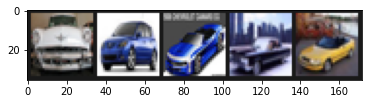

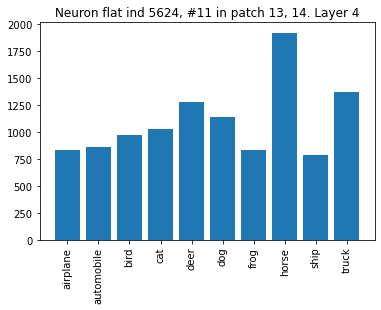

entropy is:  2.2612658
activation amounts tensor([4.5346, 4.4648, 4.4145, 4.3643, 4.3261])


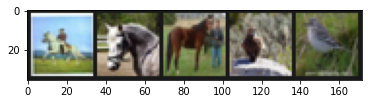

In [19]:
from torchvision import transforms
num_patches = activation_storage.shape[-1]
master_ind = torch.arange(class_acts.shape[1]).view(params.nneurons_per_filter, num_patches, num_patches)
for i in range(10):
    ind = np.random.choice(nonzs, 1)[0]
    plt.bar(data_classes, class_acts[:,ind])
    nind, px, py = (master_ind == ind).nonzero(as_tuple=True)
    nind, px, py = int(nind), int(px), int(py)
    plt.title(f"Neuron flat ind {ind}, #{nind} in patch {px}, {py}. Layer {lind}")
    if params.dataset_str == "CIFAR10":
        plt.xticks(rotation=90)
    plt.show()

    # test entropy calc 
    act_pdf = class_acts[:,ind] / class_acts[:,ind].sum() 
    z_inds = (act_pdf==0.0)
    act_pdf[z_inds] += 1e-15
    print("entropy is: ",-(act_pdf * np.log(act_pdf)).sum(0))
    
    nacts_to_plot = 5
    
    # what specific inputs activate this neuron the most and the least? 
    vals, inds = torch.topk(activation_storage[:, nind, :, px, py], nacts_to_plot, dim=0) 
    print("activation amounts", vals.flatten())
    tp = data_module.test_data.data[inds]
    tp = pre_make_grid_tensor(tp)
            
    imshow(make_grid(tp, nrow=nacts_to_plot, padding=2, pad_value=0.1), show_now=True)
    
    print('========')

In [20]:
lind = 7
activation_storage = layerwise_activation_storage[lind]
activation_storage.shape 

torch.Size([10000, 10])

In [21]:
activation_storage.shape

torch.Size([10000, 10])

In [22]:
if alexnet: 
    # as these are not L2 normalized I need to scale them within the specific logit prediction
    activation_storage = F.softmax( activation_storage , dim=1)

In [23]:
flat_act = activation_storage.flatten(start_dim=1)
df = pd.DataFrame( flat_act.cpu().numpy(), columns=list(np.arange(flat_act.shape[1])) )
df["Labels"] = data_labels
df.set_index('Labels', inplace=True)

class_acts = df.groupby("Labels").agg('sum').values
class_acts.shape

(10, 10)

In [24]:
df.sum(1)

Labels
3    348.131226
8    370.719360
8    381.248108
0    377.721527
6    381.134460
        ...    
8    325.584473
3    358.552032
5    403.845490
1    360.471588
7    321.874817
Length: 10000, dtype: float32

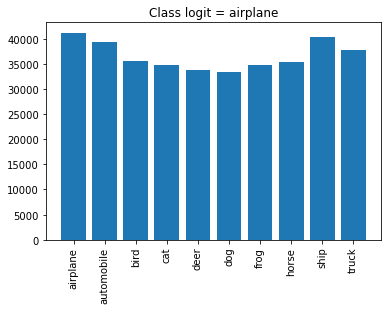

entropy is:  2.2999587
tensor([57.6805, 57.3870, 56.7834, 56.5827, 55.6977])


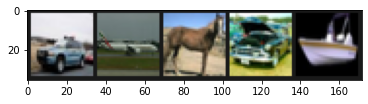

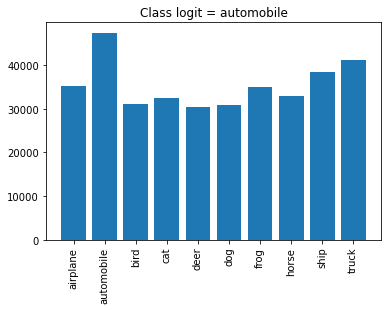

entropy is:  2.2925234
tensor([73.6895, 72.6611, 69.0586, 68.9785, 67.7830])


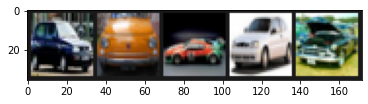

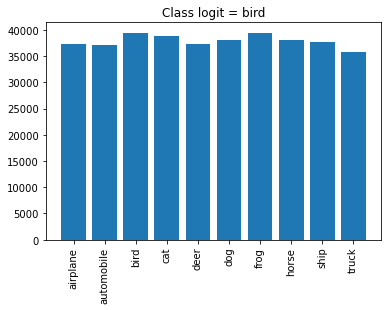

entropy is:  2.302185
tensor([56.9276, 56.4602, 56.1167, 53.2802, 53.1089])


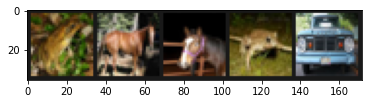

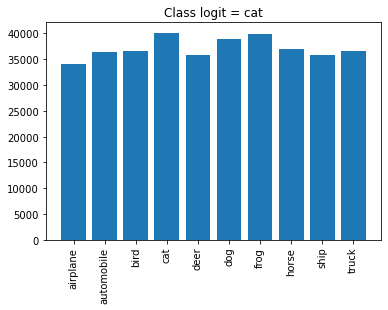

entropy is:  2.301378
tensor([60.2762, 58.0968, 55.6586, 55.2882, 55.2523])


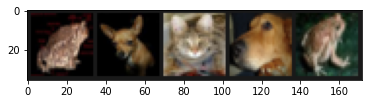

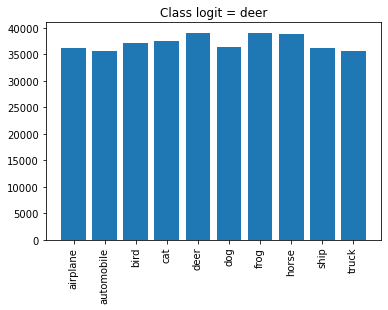

entropy is:  2.301952
tensor([58.1024, 57.5181, 54.2889, 54.1964, 53.6409])


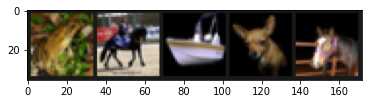

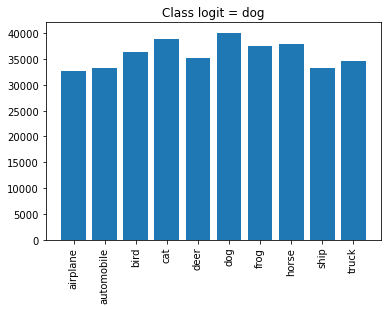

entropy is:  2.3003194
tensor([56.6301, 56.6191, 54.8871, 54.7193, 54.6696])


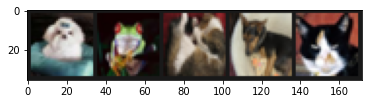

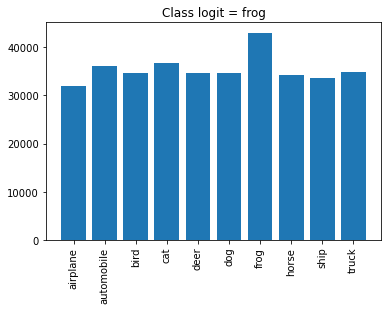

entropy is:  2.2995656
tensor([65.0955, 60.8241, 59.6523, 59.3817, 59.2395])


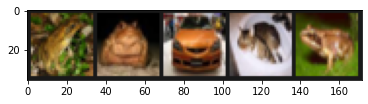

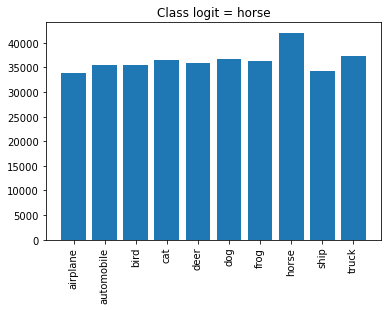

entropy is:  2.300907
tensor([66.5171, 61.1574, 60.1397, 60.1185, 59.6964])


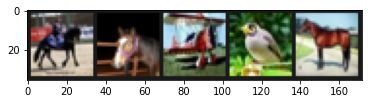

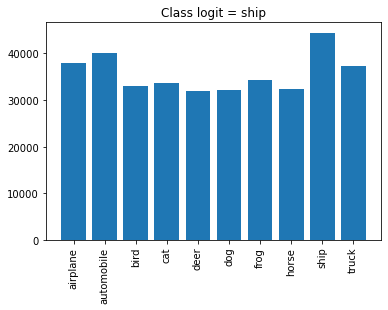

entropy is:  2.296633
tensor([66.6617, 65.5756, 63.0533, 62.6583, 62.3888])


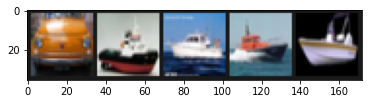

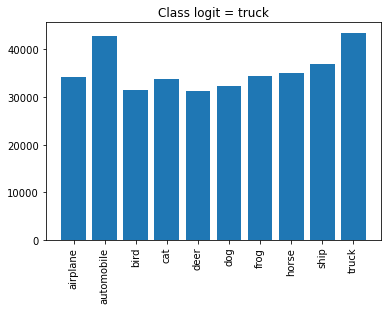

entropy is:  2.2960806
tensor([64.6524, 64.4570, 62.4850, 61.4478, 60.9100])


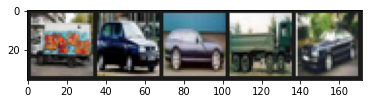

In [25]:
for ind in range(10):    
    plt.bar(data_classes, class_acts[:,ind])
    if params.dataset_str == "CIFAR10":
        plt.xticks(rotation=90)
    
    plt.title(f"Class logit = {data_classes[ind]}")
    plt.show()

    act_pdf = class_acts[:,ind] / class_acts[:,ind].sum() 
    z_inds = (act_pdf==0.0)
    act_pdf[z_inds] += 1e-15
    print("entropy is: ",-(act_pdf * np.log(act_pdf)).sum(0))
    
    nacts_to_plot = 5
    
    # what specific inputs activate this neuron the most and the least? 
    vals, inds = torch.topk(activation_storage[:, ind], nacts_to_plot, dim=0)
    print(vals)
    tp = data_module.test_data.data[inds]
    tp = pre_make_grid_tensor(tp)
    imshow(make_grid(tp, nrow=nacts_to_plot, padding=2, pad_value=0.1), show_now=True)
    
    print('========')

# Backprop on input

In [9]:
bs = 20 # batch size
lind = 7
nind = 1
px, py = 4,4

# identifying the activities of the neurons

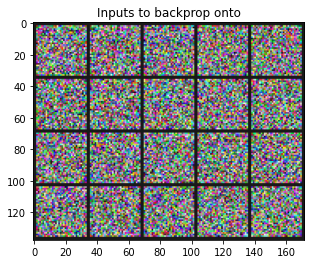

In [12]:
randoms = True
if randoms: 
    # values between 0 and 1 (are positive and within MNIST max value of 1)
    inp = torch.nn.Parameter(torch.rand((bs, model.params.nchannels, model.params.img_dim, model.params.img_dim))) #, requires_grad=True)

else: 
    
    desired_number = 1
    
    if not alexnet: 
        activation_storage = layerwise_activation_storage[lind]
    activation_storage.shape 
    
    flat_act = activation_storage[:, nind, :, px, py].flatten(start_dim=1)
    df = pd.DataFrame( flat_act.cpu().numpy(), columns=list(np.arange(flat_act.shape[1])) )
    df["Labels"] = data_labels
    df.set_index('Labels', inplace=True)

    class_acts = df.groupby("Labels").agg('sum').values
    
    plt.bar(data_classes, class_acts[:,nind])
    if params.dataset_str == "CIFAR10":
        plt.xticks(rotation=90)
    plt.show()
    
    # getting values that look like a specific number 
    data_module.setup(None, "../data/")
    test_loader = data_module.val_dataloader()

    init_images = []
    for dind, data in enumerate(test_loader):
        imgs, labels = data
        match_inds = list(torch.where(labels == desired_number) )[0]
        for mind in match_inds: 
            init_images.append(imgs[mind])

        if len(init_images)>bs: 
            break 

    init_images = torch.stack(init_images[:bs])
    init_images += torch.clamp(torch.rand_like(init_images), 0, 0.1)
    init_images = torch.clamp(init_images, 0, 1)
    inp = torch.nn.Parameter(init_images)

tp = inp.detach().cpu()
imshow(make_grid(tp, nrow=5, padding=2, pad_value=0.1), show_now=False)
plt.title(f"Inputs to backprop onto")
plt.show()

torch.Size([20]) tensor([46.7237, 47.2331, 37.9139, 51.3791, 43.1141, 42.8864, 40.1391, 43.1976,
        43.6390, 36.3890, 44.0084, 38.1760, 44.4660, 49.4630, 37.1185, 46.5657,
        38.7134, 40.7817, 38.7575, 42.6935], device='cuda:0',
       grad_fn=<SelectBackward0>)
torch.Size([20]) tensor([130.2873, 135.3703, 131.4966, 134.2447, 137.0593, 120.9230, 140.1423,
        127.1100, 129.7278, 138.4350, 124.9566, 135.3980, 135.1470, 137.7946,
        133.8391, 132.9090, 131.8946, 118.9462, 136.4370, 131.0998],
       device='cuda:0', grad_fn=<SelectBackward0>)


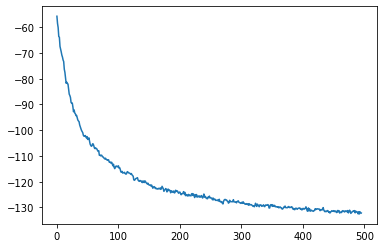

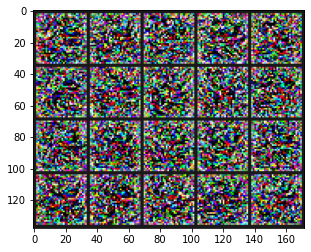

torch.Size([20]) tensor([140.3947, 140.6015, 144.0133, 139.8649, 144.1556, 131.8563, 141.3131,
        136.6271, 135.5488, 141.0468, 128.3843, 136.5096, 138.3915, 138.6391,
        139.5473, 138.6650, 138.1875, 124.9045, 137.4917, 133.8649],
       device='cuda:0', grad_fn=<SelectBackward0>)


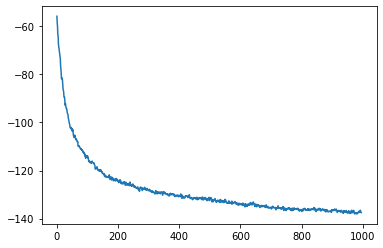

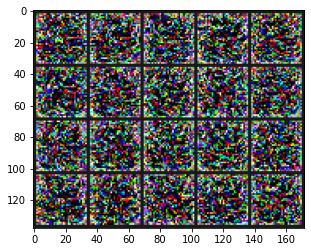

torch.Size([20]) tensor([142.3037, 144.8973, 144.5900, 141.1491, 141.0509, 140.1677, 146.2706,
        137.6817, 136.2979, 139.1680, 136.1480, 140.2794, 140.2693, 143.6831,
        140.6528, 140.6773, 142.9942, 130.8839, 138.5488, 139.1062],
       device='cuda:0', grad_fn=<SelectBackward0>)


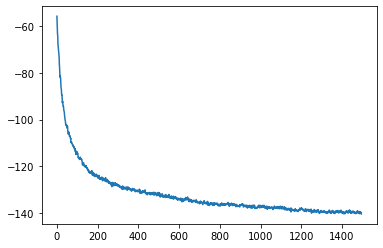

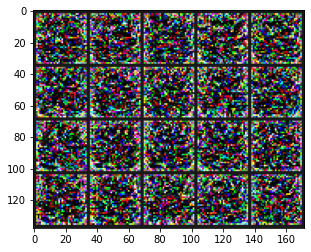

torch.Size([20]) tensor([142.1238, 142.8231, 143.5570, 142.1542, 144.3845, 142.9544, 143.3477,
        139.9002, 132.4011, 142.1348, 138.6011, 142.6190, 138.8388, 142.5972,
        142.8259, 138.5674, 140.2172, 130.0126, 142.8033, 142.2622],
       device='cuda:0', grad_fn=<SelectBackward0>)


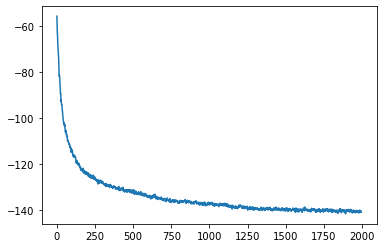

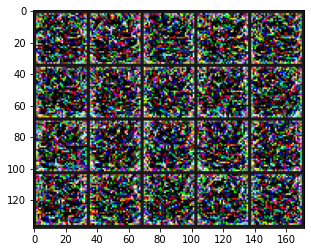

torch.Size([20]) tensor([139.6599, 141.8156, 145.9625, 141.2305, 143.2510, 142.4688, 145.3485,
        139.2503, 138.7773, 143.7675, 138.7970, 140.5721, 141.3151, 142.2278,
        139.2622, 138.0530, 136.9855, 135.4992, 139.0813, 137.8522],
       device='cuda:0', grad_fn=<SelectBackward0>)


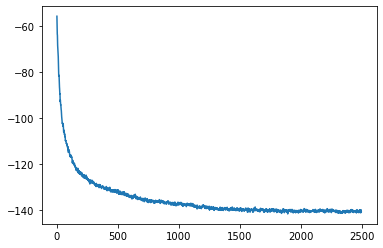

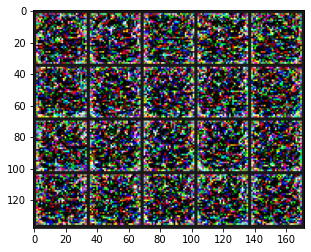

epoch 2999


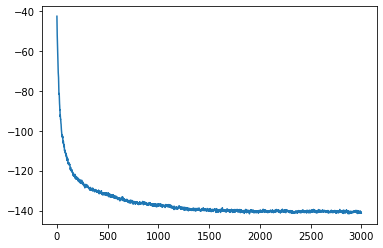

In [14]:
# neuron to optimize: 

plot, plot_interval = True, 500

softmax_alex = False 

assert lind > 0, "Need to implement for first layer still."

lr = 0.01
steps = 3000

def backprop_input(inp, model):

    model.eval()
    optimizer = optim.Adam([inp], lr=lr)
    losses = []
    
    for e in range(steps): # to train the projection matrix
        
        # training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        if alexnet: 
            logits, _ = model.forward(inp.to(device))
        else: 
            logits, activations = model.forward(inp.to(device), log_metrics=False, output_all_activations=True)
        # need to be careful in how I handle channels here. 
        if alexnet or lind == len(activations)-1:
            if softmax_alex:
                logits = F.softmax(logits, dim=1)
            nact = logits[:,nind]
        else: 
            nact = activations[lind][nind, :, :, px,py] #logits[:,1]

        # reconstruction loss after convergence iterations. 
        loss = -nact.sum() # summing across the batch. 
        loss /= bs
        loss.backward()
        
        optimizer.step() 
        
        with torch.no_grad():
            #inp = torch.nan_to_num(inp, nan=0.0)
            torch.clamp_(inp, 0.000001,1)
        inp.requires_grad = True

        losses.append(loss.item())
        
        if plot and e%plot_interval==0: 
            if e ==0:
                print(nact.shape, nact.flatten())
                continue 
            print(nact.shape, nact.flatten())
                
            plt.plot(losses[5:])
            plt.show() 
            
            tp = torch.clone(inp).detach().cpu()
            imshow(make_grid(tp, nrow=5, padding=2, pad_value=0.1), show_now=True)

            #print(inp[0].squeeze())
            
    # do a final plot of this training run. 
    print("epoch", e) 
    plt.plot(losses)
    plt.show()
    
    return inp

inp = backprop_input(inp, model)

# Look at Weights

Layer dimensions torch.Size([20, 20, 1, 1, 20, 20, 5, 5])
What is in the histogram torch.Size([20, 5, 5])


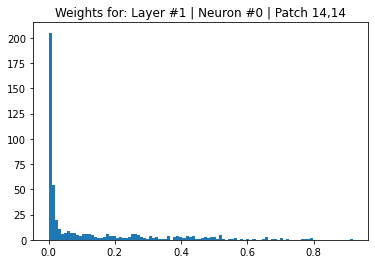

In [102]:
lind =1 # layer ind
nind = 0 # neuron ind
px= 14
py= 14
print('Layer dimensions', model.layers[lind].shape)
tohist = model.layers[lind][nind,:,0,0,px,py,:,:]
print("What is in the histogram", tohist.shape)

plt.hist(tohist.flatten().cpu().detach().numpy(), bins=100)
plt.title(f"Weights for: Layer #{lind} | Neuron #{nind} | Patch {px},{py}")
plt.show()

In [20]:
model.layers[lind][nind].shape

torch.Size([20, 1, 1, 20, 20, 5, 5])

In [21]:
ps = model.make_local_receptive_fields(x, params.filter_len)
ps.shape

torch.Size([16, 1, 24, 24, 5, 5])

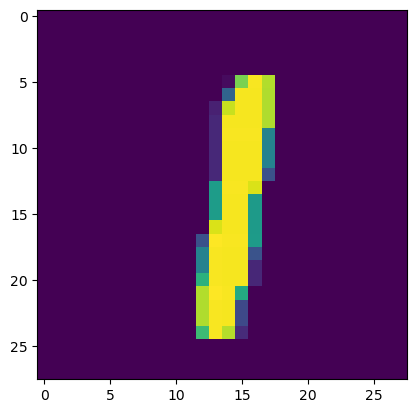

In [24]:
tplt(x[0,0])

In [25]:
ps[0,0].shape # batch and squeeze

torch.Size([24, 24, 5, 5])

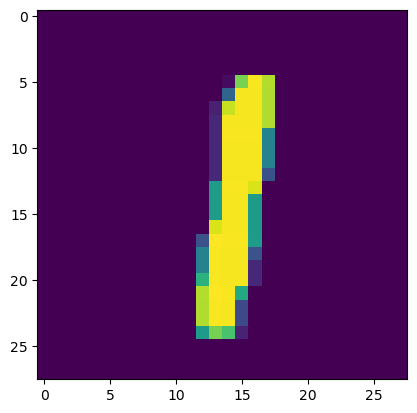

In [26]:
combo = recombine(ps[0,0])
tplt(combo)

# Plotting each of the overlapping patches 

In [ ]:

pind = 0
ps_reshaped = ps[pind].squeeze().flatten(end_dim=-3).unsqueeze(1)
ps_reshaped.shape

torch.Size([576, 1, 5, 5])

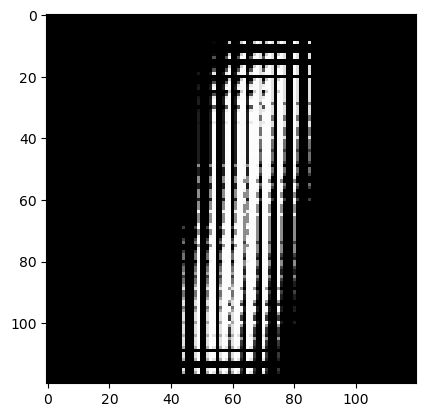

In [ ]:
imshow(make_grid(ps_reshaped.cpu(), nrow=24, padding=0))

# there are overlapping patches which is why this looks the way it does. 

# Plotting Weights

In [27]:
print( model.layers[0].shape,'\n', model.layers[1].shape)

torch.Size([20, 1, 1, 24, 24, 5, 5]) 
 torch.Size([20, 20, 1, 1, 20, 20, 5, 5])


In [28]:
kernel_len=5
nind = 3
px,py=10,10
max_px = model.layers[1].shape[-3]
# this is layer 2 selecting layer 1
# and layer 1 then correponds to the patches. but we want to account for its weights of course. 
l1 = model.layers[1][nind, :,0,0,px, py,:,:].unsqueeze(-1).unsqueeze(-1)
l1.shape

# these are the weights of a specific layer 1 neuron. Want to multiply them by the weights on layer 0. 

torch.Size([20, 5, 5, 1, 1])

In [29]:
l0 = model.layers[0][:,0,0,px:px+kernel_len, py:py+kernel_len,:,:]
l0.shape

torch.Size([20, 5, 5, 5, 5])

In [30]:
# this is all 20 of the neurons not just one. 
# and for all 25 of the patches. 
# want to visualize everything combined. Need to get it to pixel space and then recombined things? but it is in pixel space now. 
ground = l0*l1


In [31]:
ground.shape

torch.Size([20, 5, 5, 5, 5])

In [32]:
# linear combo of all the weights as a function of their weightings from the previous layer. 

# should be the topK ones rather than all of them? 

ground = ground.sum(dim=0)
ground.shape

torch.Size([5, 5, 5, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


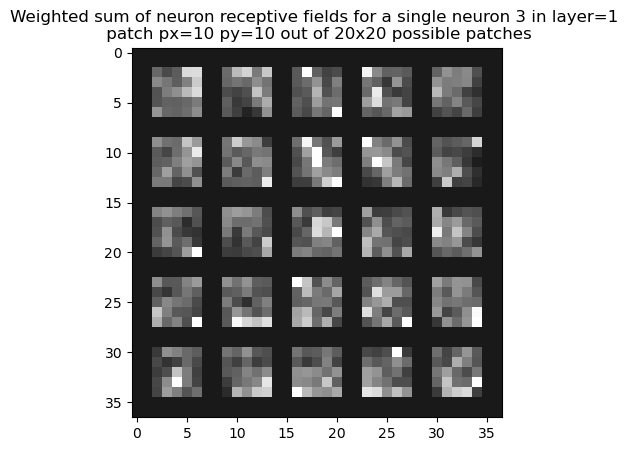

In [34]:
import torchvision
from torchvision.utils import make_grid

tp = ground.flatten(end_dim=1).unsqueeze(1).detach().cpu()
imshow(make_grid(tp, nrow=5, padding=2, pad_value=0.1), show_now=False)
plt.title(f"Weighted sum of neuron receptive fields for a single neuron {nind} in layer=1 \n patch px={px} py={py} out of {max_px}x{max_px} possible patches")
plt.show()

In [ ]:
# need to code this up and generalize it for higher dimensions!

Showing each of the neurons receptive fields within a specific patch

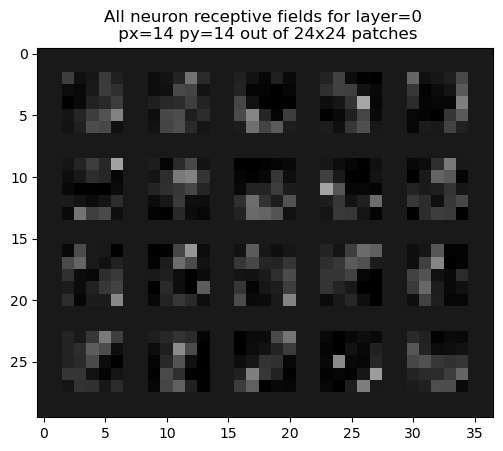

In [41]:
# flattened list, channel, sizes. 

lind =0 # layer ind
px, py = 14,14
max_px = model.layers[lind].shape[-3]

tp = model.layers[lind][:,0,0,px,py,:,:].unsqueeze(1).detach().cpu()
imshow(make_grid(tp, nrow=5, padding=2, pad_value=0.1), show_now=False)
plt.title(f"All neuron receptive fields for layer=0 \n px={px} py={py} out of {max_px}x{max_px} patches")
plt.show()

Tracking back the focus of each neuron at higher layers

In [42]:
# doing the same with the first layer of the neural network

lind =1 # layer ind
nind = 3
px, py = 10,10
max_px = model.layers[lind].shape[-3]
print('Layer dimensions', model.layers[lind].shape)
l = model.layers[lind][nind,:,0,0,px,py,:,:]
print("Neuron weights", l.shape )
l = l.flatten(start_dim=1).T.unsqueeze(-1)
l.shape


Layer dimensions torch.Size([20, 20, 1, 1, 20, 20, 5, 5])
Neuron weights torch.Size([20, 5, 5])


torch.Size([25, 20, 1])

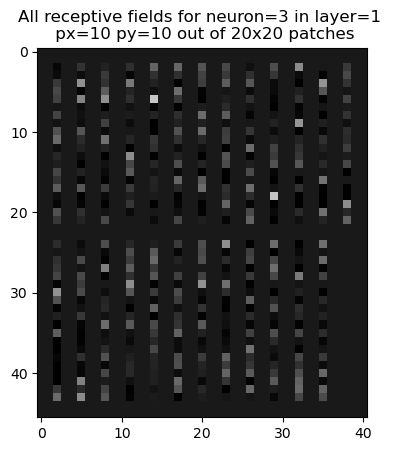

In [44]:
# flattened list, channel, sizes. 
tp = l.unsqueeze(1).detach().cpu()
imshow(make_grid(tp, nrow=13, padding=2, pad_value=0.1), show_now=False)
plt.title(f"All receptive fields for neuron={nind} in layer={lind} \n px={px} py={py} out of {max_px}x{max_px} patches")
plt.show()

Looking for a given neuron index across all patches. Doesnt make that much sense to do this because each neuron is independent

In [48]:
tlist = []
for nind in range(20):
    l = model.layers[0][nind,0,0,:,:,:,:]
    recomb = recombine(l)
    tlist.append(recomb.detach().cpu())

In [51]:
tp = torch.stack(tlist).unsqueeze(1).detach().cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


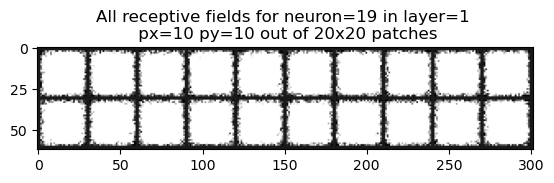

In [52]:
imshow(make_grid(tp, nrow=10, padding=2, pad_value=0.1), show_now=False)
plt.title(f"All receptive fields for neuron={nind} in layer={lind} \n px={px} py={py} out of {max_px}x{max_px} patches")
plt.show()

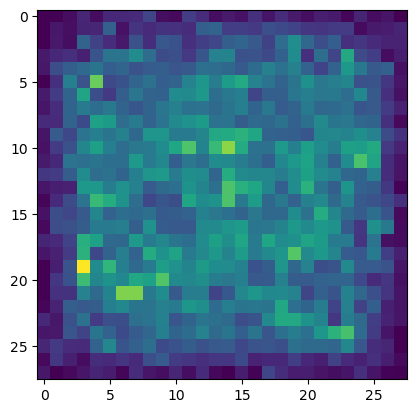

In [54]:
tplt(tlist[0])

# Extras

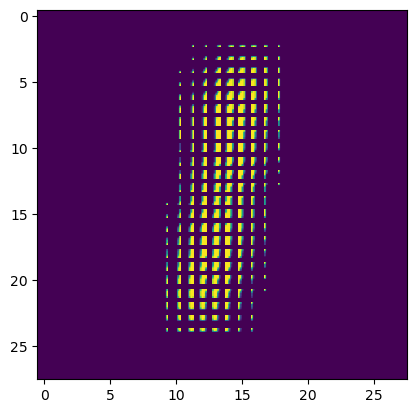

In [15]:
'''from matplotlib.offsetbox import OffsetImage, AnnotationBbox
plt.figure(1, )#figsize=(12, 8))
ax = plt.gca()
plt.imshow(np.zeros((28,28)))
for px in range(24):
    for py in range(24):
        im = OffsetImage(ps[0,0,px, py].cpu().numpy(), zoom=1.2)
        ab = AnnotationBbox(
            im, (py+1, px+1), xycoords="data", frameon=False, pad=0.0
        )
        ax.add_artist(ab)
        ax.update_datalim(np.column_stack([px+1,py+1]))
        ax.autoscale()
        #break
    #break 
plt.show()'''

In [130]:


import torch.optim as optim
import torch.nn.functional as F
lr = 0.1
model.eval()
optimizer = optim.Adam([inp], lr=lr)
losses = []

# training loop:
optimizer.zero_grad()   # zero the gradient buffers
logits, activations = model.forward(inp.to(device), logging=False, output_all_activations=True)
# need to be careful in how I handle channels here. 
if lind == len(activations)-1:
    print('using last layer')
    nact = logits[:,nind]
else: 
    nact = activations[lind][nind, :, :, px,py]

# reconstruction loss after convergence iterations. 
loss = -nact.sum() # summing across the batch. 
loss /= bs
loss.backward()
inp.grad.data[0].max(), inp.grad.data[0].min() 

using last layer


(tensor(0.0003), tensor(-0.0003))

In [ ]:
tp = inp.grad.data.detach().cpu()*1e6
imshow(make_grid(tp, nrow=4, padding=2, pad_value=0.1), show_now=True)
plt.imshow(inp.grad.data[0].detach().cpu().squeeze().numpy())

# sparse gradients? 
print( "number of sparse gradients", (~(inp.grad.data[0].abs() > 0.0)).sum() )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


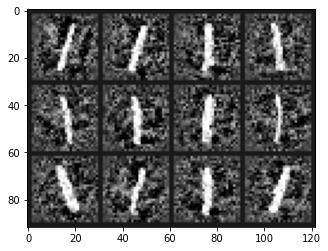

In [81]:
optimizer.step() 
tp = torch.clone(inp).detach().cpu()
imshow(make_grid(tp, nrow=4, padding=2, pad_value=0.1), show_now=True)

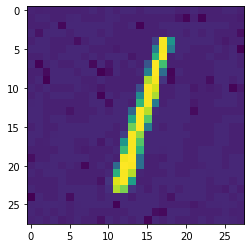

In [99]:
plt.imshow(inp[0].squeeze())

In [ ]:
!git add -A .
!git commit -m "updating code"
!git push